WIP, currently only flow model

In [1]:
#ADDITIONAL DEPENDENCIES
# #!pip install triangle
# #!pip install rasterio
# #!pip install geopy
# #!pip install osmnx

In [2]:
import sys
sys.path.append(r'C:\repos\snkit\src')
sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
from ci_adapt_utilities import *
from ci_adapt_classes import *
from ra2ce_multi_network.simplify_rail import *
from ra2ce_multi_network.simplify_rail import _merge_edges, _network_to_nx
import networkx as nx
import pandas as pd
from shapely import wkt, box

In [3]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

In [4]:
#FUNCTION DEFINITIONS
#TODO: Add cost for economic appraisal, add mode factor to edge weights for multi-modality
def get_bbox(graph):
    min_x = min([attr['pos'][0] for _, attr in graph.nodes(data=True)])
    max_x = max([attr['pos'][0] for _, attr in graph.nodes(data=True)])
    min_y = min([attr['pos'][1] for _, attr in graph.nodes(data=True)])
    max_y = max([attr['pos'][1] for _, attr in graph.nodes(data=True)])
    return min_x, max_x, min_y, max_y

def set_edge_weights(assets, graph):
    asset_lengths = {str(asset['osm_id']): asset['geometry'].length for asset_id, asset in assets.iterrows()}
    for u, v, attr in graph.edges(data=True):
        if 'source_sink' in str(u) or 'source_sink' in str(v):
            continue
        attr['weight'] = int(0)
        attr['length'] = 0
        if 'osm_id' not in attr:
            continue
        osm_ids = attr['osm_id'].split('; ')
        for osm_id in osm_ids:
            if osm_id in asset_lengths:
                attr['length'] += asset_lengths[osm_id]
                attr['weight'] += int(round(asset_lengths[osm_id]*1e3,0))

    return graph

def set_edge_capacities(graph):
    for _, _, _, attr in graph.edges(keys=True, data=True):
        if 'maxspeed' not in attr:
            attr['capacity'] = int(100000)
            continue
        asset_speeds = attr['maxspeed'].split('; ') if attr['maxspeed'] else []
        if len(asset_speeds) > 0:
            attr['capacity'] = 1000*int(min(asset_speeds)) #TODO: Add capacity based on speed? area average trains per year?
        else: attr['capacity'] = int(100)
    return graph

def nearest_nodes(graph, point, n):
    nearest_nodes = []
    for node, attr in graph.nodes(data=True):
        distance = point.distance(attr['geometry'])
        nearest_nodes.append((node, distance))
    nearest_nodes = sorted(nearest_nodes, key=lambda x: x[1])
    return nearest_nodes[:n]

def set_node_demand(od_data, graph):
    for od in od_data.iterrows():
        if od[1]['geometry'].geom_type == 'Point':
            centroid = od[1]['geometry']
        else:
            centroid = od[1]['geometry'].centroid
        
        nearest_node = nearest_nodes(graph, centroid, 1)
        graph.nodes[nearest_node[0][0]]['demand'] += int(od[1]['demand']-od[1]['supply'])
    return graph

def equalize_demand_supply(graph):
    sumdem=0 
    for u,attr in graph.nodes(data=True):
        if attr['demand'] !=0:
            sumdem+=int(attr['demand'])

    graph.add_node('source_sink', demand=int(-sumdem), pos=graph.nodes[0]['pos'])
    for u, attr in graph.nodes(data=True):
        if u == 'source_sink':
            continue
        if not graph.has_edge(u, 'source_sink', 0):
            graph.add_edge(u,'source_sink', 0, weight=int(1e8))
        if not graph.has_edge('source_sink', u):
            graph.add_edge('source_sink', u, 0, weight=int(1e8))

    return graph

def inspect_graph(graph):
    edge_capacities_types = []
    edge_weights_types = []
    node_demands_types = []

    for _, _, attr in graph.edges(data=True):
        if 'capacity' in attr:
            edge_capacities_types.append(type(attr['capacity']))
        if 'weight' in attr:
            edge_weights_types.append(type(attr['weight']))

    for _, attr in graph.nodes(data=True):
        if 'demand' in attr:
            node_demands_types.append(type(attr['demand']))

    return edge_capacities_types, edge_weights_types, node_demands_types


In [5]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = gpd.read_file(assets_path)
assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
assets = assets.loc[assets.geometry.geom_type == 'LineString']
assets = assets.rename(columns={'railway' : 'asset'})

# #TODO: add reset index and test 
# # Drop passenger lines and light rails
# assets = assets.loc[~(assets['railway:traffic_mode'] == 'passenger')]
# assets = assets.loc[~(assets['asset'] == 'light_rail')]

# # Drop bridges and tunnels
# assets = assets.loc[~(assets['bridge'].isin(['yes']))]
# assets = assets.loc[~(assets['tunnel'].isin(['yes']))]

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

3530 assets loaded.


In [6]:
#Source: Asgarpour/snkit
# Create a railway networks with possible terminal nodes. This returns a complex network, as includes the rail tracks with the highest level of detail.
aggregation_range = 0.08 # in km
complex_rail_network = get_rail_network_with_terminals(network_gdf=assets, aggregation_range=aggregation_range)
merged_rail_network = _merge_edges(network=complex_rail_network, excluded_edge_types=['bridge', 'tunnel']) #Must add network= to pass excluded_edge_types as a keyword argument

# Number of nodes and edges reduced
print(f"Difference in node counts: {complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0]}")
print(f"Difference in node counts %: {round(100*(complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0])/complex_rail_network.nodes.shape[0], 0)}")
print(f"Difference in edge counts: {complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0]}")
print(f"Difference in edge counts %: {round(100*(complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0])/complex_rail_network.edges.shape[0], 0)}")


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A

Difference in node counts: 746
Difference in node counts %: 19.0
Difference in edge counts: 753
Difference in edge counts %: 18.0


C:\repos\ra2ce_multi_network\ra2ce_multi_network\simplify_rail.py:397: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  network.edges['length'] = network.edges['geometry'].length * 111.32  # length in km


In [7]:
merged_rail_graph = _network_to_nx(merged_rail_network)

G=nx.MultiDiGraph(merged_rail_graph)

for _, attr in G.nodes(data=True):
    attr['demand'] = int(0)
    attr['pos'] = (attr['geometry'].x, attr['geometry'].y)

In [8]:
bbox=get_bbox(G)

od_data_source = r'C:\Data\interim\od_data_2.csv'
od_data = pd.read_csv(od_data_source)
# Drop rows where 'geometry' is NaN
od_data = od_data.dropna(subset=['geometry'])
od_data['geometry'] = od_data['geometry'].apply(wkt.loads)
bbox_shape=box(bbox[0],bbox[1], bbox[2], bbox[3])
od_data = od_data[od_data['geometry'].apply(lambda geom: bbox_shape.contains(geom))]

In [9]:

G = set_node_demand(od_data, G)
G = equalize_demand_supply(G)
G = set_edge_capacities(G)
G = set_edge_weights(assets, G)

In [10]:

#Source: SA
max_weight_graph = max(attr['weight'] for _, _, attr in G.edges(data=True))
print('Max weight: '+str(max_weight_graph))
max_capacity_graph = max(attr['capacity'] for _, _, attr in G.edges(data=True))
print('Max capacity: '+str(max_capacity_graph))

# create a virtual node with dummy nodes
G_v=G.copy()
# convert to int
for u, v, key, attr in G.edges(keys=True, data=True):
    G_v.add_edge((str(u) + '_d'), (str(v) + '_d'), **attr)

for u in G.nodes:
    G_v.add_edge(u,(str(u) + '_d'),capacity=max_capacity_graph*100,weight=int(round(max_weight_graph*1e3,0)))
    G_v.add_edge((str(u) + '_d'),u,capacity=max_capacity_graph*100,weight=0)

# verify capacities, weights and demands are integers
edge_capacities_types, edge_weights_types, node_demands_types = inspect_graph(G_v)
print("Edge Capacities Types:", set(edge_capacities_types))
print("Edge Weights Types:", set(edge_weights_types))
print("Node Demands Types:", set(node_demands_types))
if {type(int())} == set(list(edge_capacities_types) + list(edge_weights_types) + list(node_demands_types)):
    print('Success: only int type values')
else: 
    print('Warning! Not all values are integers')


Max weight: 100000000
Max capacity: 300000
Edge Capacities Types: {<class 'int'>}
Edge Weights Types: {<class 'int'>}
Node Demands Types: {<class 'int'>}
Success: only int type values


In [11]:
# solve the min cost flow problem
mcf=nx.min_cost_flow(G_v)
print('Minimum cost flow: '+str(mcf))

flow_dict = mcf


Minimum cost flow: {0: {2228: {0: 0}, 'source_sink': {0: 0}, '0_d': {0: 0}}, 2: {3: {0: 0}, 2252: {0: 0}, 'source_sink': {0: 0}, '2_d': {0: 0}}, 3: {2: {0: 0}, 3008: {0: 0}, 'source_sink': {0: 0}, '3_d': {0: 0}}, 4: {2385: {0: 0}, 2566: {0: 0}, 'source_sink': {0: 0}, '4_d': {0: 0}}, 5: {2385: {0: 0}, 46: {0: 0}, 58: {0: 0}, 'source_sink': {0: 0}, '5_d': {0: 0}}, 6: {7: {0: 0}, 2685: {0: 0}, 'source_sink': {0: 0}, '6_d': {0: 0}}, 7: {6: {0: 0}, 32: {0: 0}, 'source_sink': {0: 0}, '7_d': {0: 0}}, 8: {478: {0: 0}, 472: {0: 0}, 'source_sink': {0: 0}, '8_d': {0: 0}}, 10: {2386: {0: 0}, 55: {0: 0}, 334: {0: 0}, 'source_sink': {0: 0}, '10_d': {0: 0}}, 11: {2386: {0: 0}, 2567: {0: 0}, 'source_sink': {0: 0}, '11_d': {0: 0}}, 13: {2723: {0: 0}, 2722: {0: 0}, 975: {0: 0}, 'source_sink': {0: 0}, '13_d': {0: 0}}, 14: {15: {0: 0}, 16: {0: 0}, 'source_sink': {0: 0}, '14_d': {0: 0}}, 15: {14: {0: 0}, 2720: {0: 0}, 'source_sink': {0: 0}, '15_d': {0: 0}}, 16: {14: {0: 0}, 17: {0: 0}, 'source_sink': {0: 0

Error in setting node source_sink position


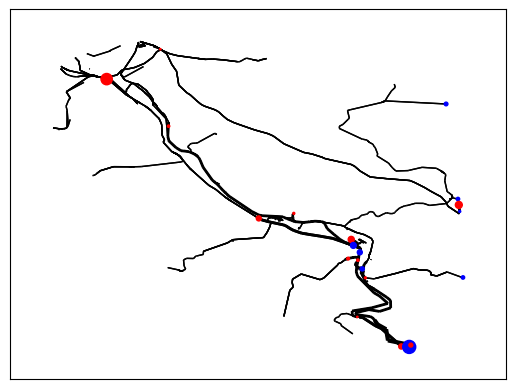

In [12]:

#visualisation
import re
from math import ceil
extract_numeric_part = lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else None

for u,attr in G_v.nodes(data=True):
    try:
        if isinstance(u, int): 
            pass
        elif isinstance(u, str): 
            if u == 'source_sink_d':
                attr['pos']=(G.nodes['source_sink']['pos'][0],G_v.nodes['source_sink']['pos'][-1])
            else:
                attr['pos']=(G_v.nodes[extract_numeric_part(u)]['pos'][0]+0.0005,G_v.nodes[extract_numeric_part(u)]['pos'][-1]+0.0005)
    except:
        print(f'Error in setting node {u} position')    
pos=nx.get_node_attributes(G_v, 'pos')
nodelist=[u for u, attr in G_v.nodes(data=True) if 'demand' in attr and attr['demand'] != 0]
edgelist=[(u, v) for u, v, attr in G.edges(data=True) if (type(u) == int and type(v) == int)]
node_size=[int(abs(ceil(attr['demand']/100))) for u, attr in G_v.nodes(data=True) if 'demand' in attr and attr['demand'] != 0]
width=[int(ceil(mcf[u][v][0]/500)+1) for u, v in edgelist]
# draw network
nx.draw_networkx(G_v, pos,
        nodelist=nodelist,
        edgelist=edgelist,
        with_labels=False, 
        arrows=False,
        node_size=node_size,
        node_color=['red' if attr['demand'] > 0 else 'blue' for u, attr in G_v.nodes(data=True) if 'demand' in attr and attr['demand'] != 0],
        width=width,
        edge_color=None)
